# Part V. Semi-supervised Classification on Cardiotocography Data Set

In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt

In [2]:
p5_train = pd.read_csv('CTG/CTG_Train_labeled.csv')
p5_train_unlabel = pd.read_csv('CTG/CTG_Train_unlabeled.csv')
p5_test  = pd.read_csv('CTG/CTG_Test.csv')
p5_train_unlabel.dropna(inplace=True)
p5_test.dropna(inplace=True)

In [3]:
p5_train_x = p5_train.iloc[:, :-1].copy()
p5_train_y = p5_train.iloc[:, -1].copy().astype('category').to_numpy()

p5_test_x = p5_test.iloc[:, :-1].copy()
p5_test_y = p5_test.iloc[:, -1].copy().astype('category').to_numpy()

NUM_FEATS = p5_train_x.shape[1]
NUM_CLASS = len(pd.unique(p5_train_y))

1. Try three classification methods using only labelled training data, and test their performances on the test data. Please try to optimize the tuning parameters as best as you can. Report the results and conclusions.

# Random forest

max predictors = 5,n trees = 25,cv error = 0.09600000000000009
max predictors = 5,n trees = 50,cv error = 0.09600000000000009
max predictors = 5,n trees = 100,cv error = 0.09999999999999998
max predictors = 10,n trees = 25,cv error = 0.09600000000000009
max predictors = 10,n trees = 50,cv error = 0.10399999999999987
max predictors = 10,n trees = 100,cv error = 0.09999999999999998
        5      10
25   0.096  0.096
50   0.096  0.104
100  0.100  0.100


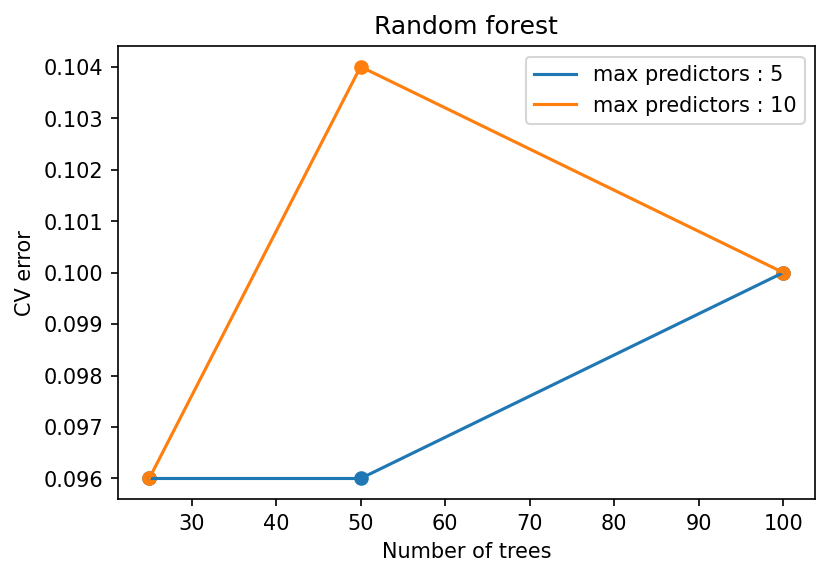

In [4]:
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict 
from sklearn.model_selection import cross_val_score

p5_rf_cv_errs = defaultdict(lambda: defaultdict(float))
max_predictors = [5, NUM_FEATS//2]  # sqrt, 10
n_trees = [25, 50, 100]
for max_predictor in max_predictors:
    for n_tree in n_trees:
        p5_rf = RandomForestClassifier(n_estimators = n_tree,  
                                   max_features=max_predictor , 
                                   bootstrap=True,
                                   random_state = 42)
        cv_err = 1 - (np.mean(cross_val_score(p5_rf, p5_train_x, p5_train_y, cv=5)))
        p5_rf_cv_errs[max_predictor][n_tree] = cv_err
            
        print(f'max predictors = {max_predictor},n trees = {n_tree},cv error = {cv_err}')

p5_rf_cv_errs_df = pd.DataFrame(p5_rf_cv_errs)
print(p5_rf_cv_errs_df)
        
plt.figure(dpi = 150)
plt.title('Random forest')
for col in p5_rf_cv_errs_df.columns:
    plt.plot(p5_rf_cv_errs_df.index, p5_rf_cv_errs_df[col], label=f'max predictors : {col}')
    plt.scatter(p5_rf_cv_errs_df.index, p5_rf_cv_errs_df[col])
plt.ylabel('CV error')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

The best parameters are: max features: 5 and n trees: 25

In [5]:
p5_best_rf = RandomForestClassifier(n_estimators = 25,  
                                   max_features=5,
                                   bootstrap=True,
                                   random_state = 42)
p5_best_rf.fit(p5_train_x, p5_train_y)

RandomForestClassifier(max_features=5, n_estimators=25, random_state=42)

# Boosting tree

max depth = 3, n trees = 25, cv error = 0.09999999999999998
max depth = 3, n trees = 50, cv error = 0.09000000000000008
max depth = 3, n trees = 75, cv error = 0.08399999999999996
max depth = 3, n trees = 100, cv error = 0.08399999999999996
max depth = 5, n trees = 25, cv error = 0.09999999999999998
max depth = 5, n trees = 50, cv error = 0.09000000000000008
max depth = 5, n trees = 75, cv error = 0.08399999999999996
max depth = 5, n trees = 100, cv error = 0.08399999999999996
CV matrix for different parameters:
         3      5
25   0.100  0.100
50   0.090  0.090
75   0.084  0.084
100  0.084  0.084


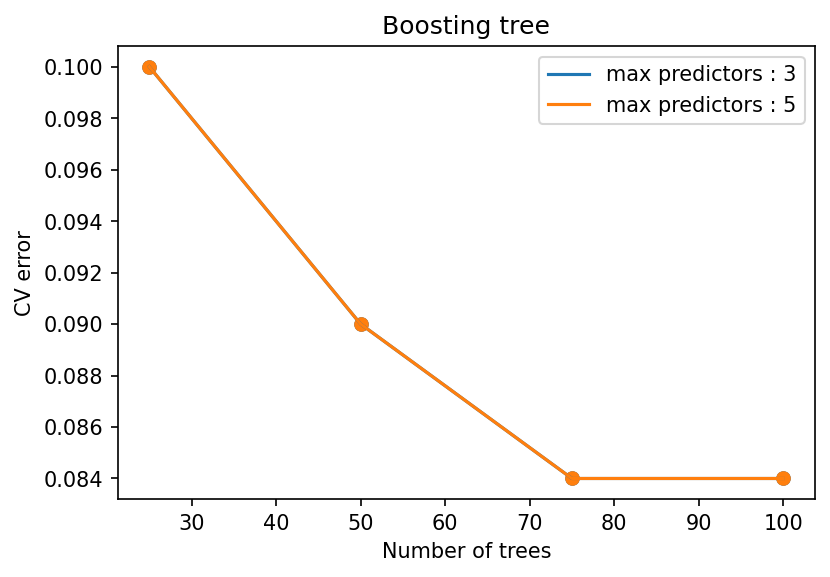

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
p5_gb_cv_errs = defaultdict(lambda: defaultdict(float))

p5_gb_cv_errs = defaultdict(lambda: defaultdict(float))
max_depths = [3, 5]
n_trees = [25, 50, 75, 100]
for max_depth in max_depths:
    for n_tree in n_trees:
        p5_gbc = GradientBoostingClassifier(n_estimators = n_tree,  
                                   max_depth=max_depth, 
                                   random_state = 42)
        
        cv_err = 1 - (np.mean(cross_val_score(p5_gbc, p5_train_x, p5_train_y, cv=5, n_jobs=4)))
        p5_gb_cv_errs[max_depth][n_tree] = cv_err
        print(f'max depth = {max_depth}, n trees = {n_tree}, cv error = {cv_err}')
        

p5_gb_cv_errs_df = pd.DataFrame(p5_gb_cv_errs)
print("CV matrix for different parameters:")
print(p5_gb_cv_errs_df)



plt.figure(dpi = 150)
plt.title('Boosting tree')
for col in p5_gb_cv_errs_df.columns:
    plt.plot(p5_gb_cv_errs_df.index, p5_gb_cv_errs_df[col], label=f'max predictors : {col}')
    plt.scatter(p5_gb_cv_errs_df.index, p5_gb_cv_errs_df[col])
plt.legend()
plt.ylabel('CV error')
plt.xlabel('Number of trees')
plt.show()

The best parameters are: max depth: 5 and n trees: 75

In [7]:
p5_best_gbc = GradientBoostingClassifier(n_estimators = 75,  # number of tree
                                   max_depth=5, # depth of tree
                                   random_state = 42)
p5_best_gbc.fit(p5_train_x, p5_train_y)

GradientBoostingClassifier(max_depth=5, n_estimators=75, random_state=42)

# SVM

In [8]:
from sklearn.svm import SVC, LinearSVC

p5_linear_svm_cvs = []
cost_range = [0.1, 1, 5, 10, 15]
for i in cost_range:
    linear_svm = LinearSVC(C = i, dual=False, random_state=42)  # Prefer dual=False when n_samples > n_features.
    linear_svm_cv_err = 1 - (np.mean(
                            cross_val_score(linear_svm, 
                                            p5_train_x, p5_train_y, cv=5)
                            ))
    p5_linear_svm_cvs.append(linear_svm_cv_err)
    print(linear_svm, linear_svm_cv_err)

LinearSVC(C=0.1, dual=False, random_state=42) 0.17400000000000004
LinearSVC(C=1, dual=False, random_state=42) 0.16799999999999993
LinearSVC(C=5, dual=False, random_state=42) 0.17200000000000004
LinearSVC(C=10, dual=False, random_state=42) 0.17000000000000015
LinearSVC(C=15, dual=False, random_state=42) 0.17400000000000004


In [9]:
p5_best_svm = LinearSVC(C = 10, dual=False,
                           random_state = 42)
p5_best_svm.fit(p5_train_x, p5_train_y)

LinearSVC(C=10, dual=False, random_state=42)

In [10]:
p5_rf_hat = p5_best_rf.predict(p5_test_x)

p5_gb_hat = p5_best_gbc.predict(p5_test_x)

p5_svm_hat = p5_best_svm.predict(p5_test_x)

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score


def evaluate_prediction(true, pred):

    print('confusion matrix')
    print(confusion_matrix(true, pred))
    print()
    
    print('accuracy score')
    print(accuracy_score(true, pred))
    print()
    
    print('precision score')
    print(precision_score(true, pred, average='weighted'))
    print()
    
    print('recall score')
    print(recall_score(true, pred, average='weighted'))
    print()
    return confusion_matrix(true, pred),accuracy_score(true, pred)


In [12]:
print("Random forest")
print()
p5_rf_cmat, p5_rf_acc = evaluate_prediction(p5_test_y ,p5_rf_hat)
print(f"Misclassification error: {1 - p5_rf_acc}\n\n")

Random forest

confusion matrix
[[374   5   1]
 [ 23  49   3]
 [  3   8  33]]

accuracy score
0.9138276553106213

precision score
0.9094537811455518

recall score
0.9138276553106213

Misclassification error: 0.08617234468937873




In [13]:
print("Gradient boosting")
print()
p5_gb_cmat, p5_gb_acc= evaluate_prediction(p5_test_y ,p5_gb_hat)
print(f"Misclassification error: {1 - p5_gb_acc}\n\n")

Gradient boosting

confusion matrix
[[367  10   3]
 [ 19  53   3]
 [  4   4  36]]

accuracy score
0.9138276553106213

precision score
0.9110869489238167

recall score
0.9138276553106213

Misclassification error: 0.08617234468937873




In [14]:
print("SVM - linear")
print()
p5_svm_cmat, p5_svm_acc = evaluate_prediction(p5_test_y ,p5_svm_hat)
print(f"Misclassification error: {1 - p5_svm_acc}")

SVM - linear

confusion matrix
[[374   1   5]
 [ 50  17   8]
 [ 10   6  28]]

accuracy score
0.8396793587174348

precision score
0.8229242851218904

recall score
0.8396793587174348

Misclassification error: 0.16032064128256518


[[0.01578947 0.03421053 0.01578947]
 [0.34666667 0.29333333 0.77333333]
 [0.25       0.18181818 0.36363636]]


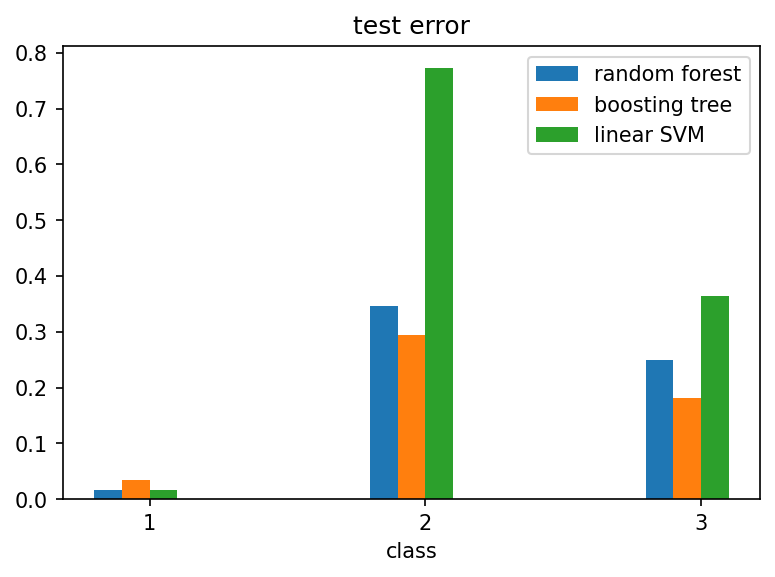

In [15]:
p5_errors_per_class = np.zeros((NUM_CLASS,3))
for clz_idx in range(NUM_CLASS):
    p5_errors_per_class[clz_idx][0] = 1 - (p5_rf_cmat[clz_idx][clz_idx]/np.sum(p5_rf_cmat[clz_idx]))
    p5_errors_per_class[clz_idx][1] = 1 - (p5_gb_cmat[clz_idx][clz_idx]/np.sum(p5_gb_cmat[clz_idx]))
    p5_errors_per_class[clz_idx][2] = 1 - (p5_svm_cmat[clz_idx][clz_idx]/np.sum(p5_svm_cmat[clz_idx]))
print(p5_errors_per_class)

x = np.arange(NUM_CLASS)
width = 0.35
fig, ax = plt.subplots(dpi = 150 )
ax.set_title('test error')
_ = ax.bar(x - 0.15, p5_errors_per_class[:,0], 0.1, label='random forest')
_ = ax.bar(x - 0.05, p5_errors_per_class[:,1], 0.1, label='boosting tree')
_ = ax.bar(x + 0.05, p5_errors_per_class[:,2], 0.1, label='linear SVM')

ax.set_xticks(x)
ax.set_xticklabels(p5_best_svm.classes_)
ax.set_xlabel('class')
ax.legend()
plt.show()

From above figure, we draw a conclusion that the performances of boosting tree are the best.

2. Try two semi-supervised classification methods using both labelled training data and unlabelled training data, and test their performances on the test data. Please try to optimise the tuning parameters as best as you can. Report the results and compare with the results using only labelled data.

# Self learn random forest

In [16]:
p5_train_x_sl = pd.concat((p5_train_x, p5_train_unlabel))
p5_train_y_sl = np.concatenate((p5_train_y, -1*np.ones(len(p5_train_unlabel))))

p5_best_rf = RandomForestClassifier(n_estimators = 25,  # number of tree
                                   max_features=5, # mtry in R
                                   bootstrap=True,
                                   random_state = 42)

p5_rf_cvs = []
thresholds = np.arange(0.6, 1, 0.05)
print(thresholds)

from sklearn.semi_supervised import SelfTrainingClassifier

for i in thresholds:
    self_train_rf = SelfTrainingClassifier(p5_best_rf, threshold=i)  # The decision threshold for use
    p5_rf_cv_err = 1 - (np.mean(cross_val_score(self_train_rf, 
                                                     p5_train_x_sl, 
                                                     p5_train_y_sl, 
                                                     n_jobs=4,
                                                     cv=5)
                                    ))
    p5_rf_cvs.append(p5_rf_cv_err)
    print(f"threshold: {i:.2f}, cv error: {p5_rf_cv_err:.6f}")

[0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
threshold: 0.60, cv error: 0.729561
threshold: 0.65, cv error: 0.730171
threshold: 0.70, cv error: 0.728946
threshold: 0.75, cv error: 0.728330
threshold: 0.80, cv error: 0.729559
threshold: 0.85, cv error: 0.728330
threshold: 0.90, cv error: 0.727713
threshold: 0.95, cv error: 0.727713


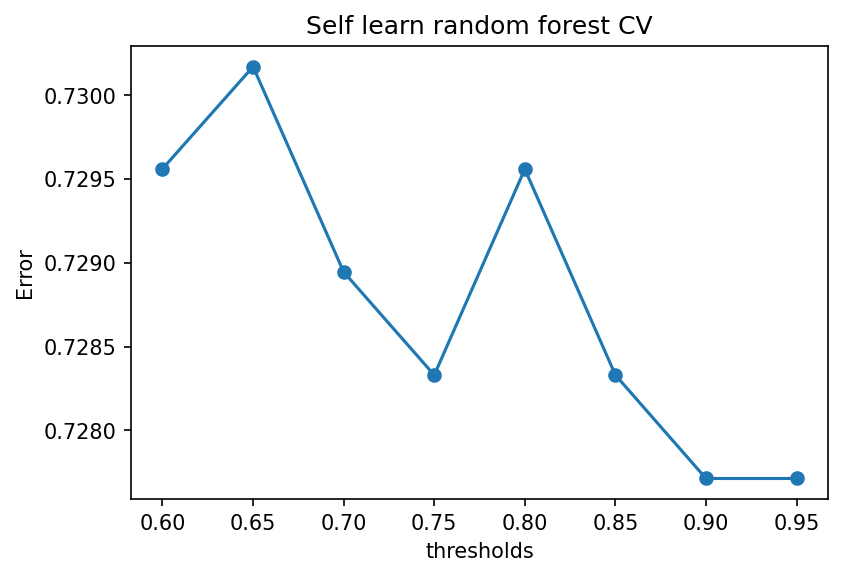

In [17]:
plt.figure(dpi = 150)
plt.title("Self learn random forest CV")
plt.plot(thresholds, p5_rf_cvs)
plt.scatter(thresholds, p5_rf_cvs)
plt.xlabel('thresholds')
plt.ylabel('Error')
plt.show()

In [18]:
self_train_rf = SelfTrainingClassifier(p5_best_rf, threshold=0.9)
self_train_rf.fit(p5_train_x_sl, p5_train_y_sl)

SelfTrainingClassifier(base_estimator=RandomForestClassifier(max_features=5,
                                                             n_estimators=25,
                                                             random_state=42),
                       threshold=0.9)

In [19]:
p5_rf_sl_hat = self_train_rf.predict(p5_test_x)
p5_rf_sl_cmat, p5_rf_sl_acc = evaluate_prediction(p5_test_y ,p5_rf_sl_hat)
print(f"Misclassification error: {1 - p5_rf_sl_acc}")

confusion matrix
[[371   6   3]
 [ 26  44   5]
 [  4   7  33]]

accuracy score
0.8977955911823647

precision score
0.8915439745644264

recall score
0.8977955911823647

Misclassification error: 0.10220440881763526


# Self learn GBT

In [20]:
p5_best_gbc = GradientBoostingClassifier(n_estimators = 75,  # number of tree
                                   max_depth=3, # depth of tree
                                   random_state = 42)

p5_gb_cvs = []
thresholds = np.arange(0.6, 1, 0.05)
print(thresholds)
for i in thresholds:
    self_train_gb = SelfTrainingClassifier(p5_best_gbc, threshold=i)  # The decision threshold for use
    p5_gb_cv_err = 1 - (np.mean(cross_val_score(self_train_gb, 
                                                     p5_train_x_sl, 
                                                     p5_train_y_sl, 
                                                     n_jobs=4,
                                                     cv=5)
                                    ))
    p5_gb_cvs.append(p5_gb_cv_err)
    print(f"threshold: {i:.2f}, cv error: {p5_gb_cv_err:.6f}")

[0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
threshold: 0.60, cv error: 0.720336
threshold: 0.65, cv error: 0.719105
threshold: 0.70, cv error: 0.720334
threshold: 0.75, cv error: 0.717874
threshold: 0.80, cv error: 0.719101
threshold: 0.85, cv error: 0.717871
threshold: 0.90, cv error: 0.718486
threshold: 0.95, cv error: 0.721559


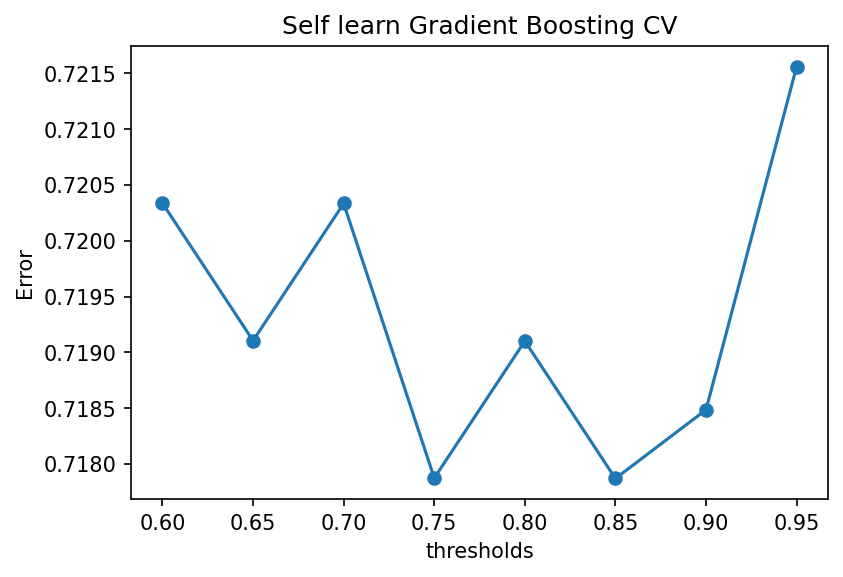

In [21]:
plt.figure(dpi = 150)
plt.title("Self learn Gradient Boosting CV")
plt.plot(thresholds, p5_gb_cvs)
plt.scatter(thresholds, p5_gb_cvs)
plt.xlabel('thresholds')
plt.ylabel('Error')
plt.show()

Threshold = 0.85 has the best performance

In [22]:
self_train_gb = SelfTrainingClassifier(p5_best_gbc, threshold=0.85)
self_train_gb.fit(p5_train_x_sl, p5_train_y_sl)

SelfTrainingClassifier(base_estimator=GradientBoostingClassifier(n_estimators=75,
                                                                 random_state=42),
                       threshold=0.85)

In [23]:
p5_gb_sl_hat = self_train_gb.predict(p5_test_x)
p5_gb_sl_cmat, p5_gb_sl_acc = evaluate_prediction(p5_test_y ,p5_gb_sl_hat)
print(f"Misclassification error: {1 - p5_gb_sl_acc}")

confusion matrix
[[366  12   2]
 [ 18  57   0]
 [  2   5  37]]

accuracy score
0.9218436873747495

precision score
0.9214924666189891

recall score
0.9218436873747495

Misclassification error: 0.07815631262525047


In [24]:
p5_sl_errors_per_class = np.zeros((NUM_CLASS,2))
for clz_idx in range(NUM_CLASS):
    p5_sl_errors_per_class[clz_idx][0] = 1 - (p5_rf_sl_cmat[clz_idx][clz_idx]/np.sum(p5_rf_sl_cmat[clz_idx]))
    p5_sl_errors_per_class[clz_idx][1] = 1 - (p5_gb_sl_cmat[clz_idx][clz_idx]/np.sum(p5_gb_sl_cmat[clz_idx]))
print(p5_sl_errors_per_class)

[[0.02368421 0.03684211]
 [0.41333333 0.24      ]
 [0.25       0.15909091]]


# Comparison

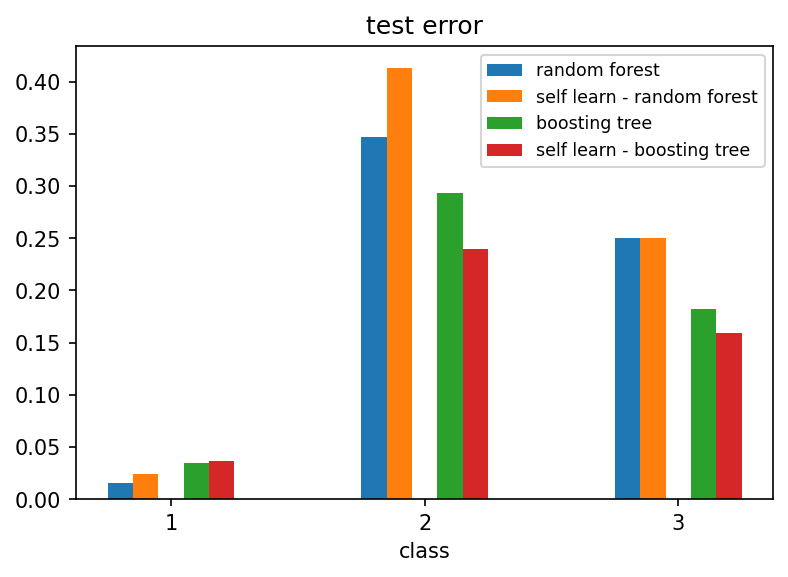

In [25]:
x = np.arange(NUM_CLASS)
width = 0.35
fig, ax = plt.subplots(dpi = 150 )
ax.set_title('test error')
_ = ax.bar(x - 0.2, p5_errors_per_class[:,0], 0.1, label='random forest')
_ = ax.bar(x - 0.1, p5_sl_errors_per_class[:,0], 0.1, label='self learn - random forest')

_ = ax.bar(x + 0.1, p5_errors_per_class[:,1], 0.1, label='boosting tree')
_ = ax.bar(x + 0.2, p5_sl_errors_per_class[:,1], 0.1, label='self learn - boosting tree')

ax.set_xticks(x)
ax.set_xticklabels(p5_best_svm.classes_)
ax.set_xlabel('class')
ax.legend(fontsize = 'small')
plt.show()

From the above plot, we draw a conclusion that the self learning version is better than original version in general.Among all the models, self-learning boosting tree has the best performance.